размер датасета: (1121442, 3)
колонки: ['audio_path', 'text_path', 'duration']
всего записей: 1,121,442
пропущенные значения:
audio_path    3
text_path     3
duration      3
dtype: int64
count    1.121439e+06
mean     6.755528e+00
std      6.727824e+00
min      3.200000e-01
25%      2.740000e+00
50%      4.960000e+00
75%      7.900000e+00
max      1.256000e+02
Name: duration, dtype: float64


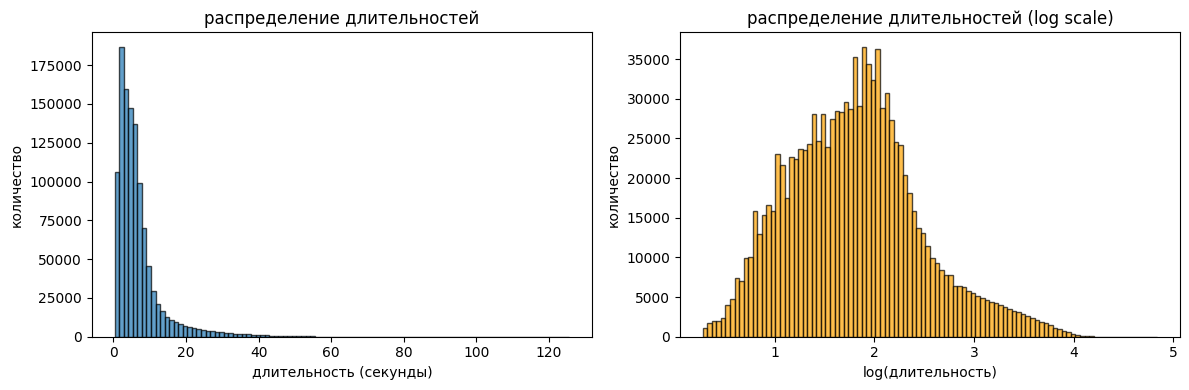


 =================== анализ структуры данных ===================
dataset_type
radio_2          651645
radio-v4         380157
public_speech     85003
radio_v4_add       4634
Name: count, dtype: int64

 =================== проверка доступности файлов =================== 


проверка файлов: 100%|██████████| 100/100 [00:00<00:00, 48039.22it/s]


аудио файлы: 57.0% доступно
текст файлы: 57.0% доступно

 =================== предобраотка текста =================== 


загрузка текстов: 100%|██████████| 1000/1000 [00:00<00:00, 6005.07it/s]


средняя длина текста: 111.7 символов
медианная длина текста: 71.0 символов
примеры текстов:
'погружается на огромную глубину и он представьте себе ситуацию был единственный человек в мире котор...'
'лам безусловно хочу но я очень надеюсь что у...'
'е это результат работы австрийских органов правосудия которые раскрыли это преступление в считанные ...'


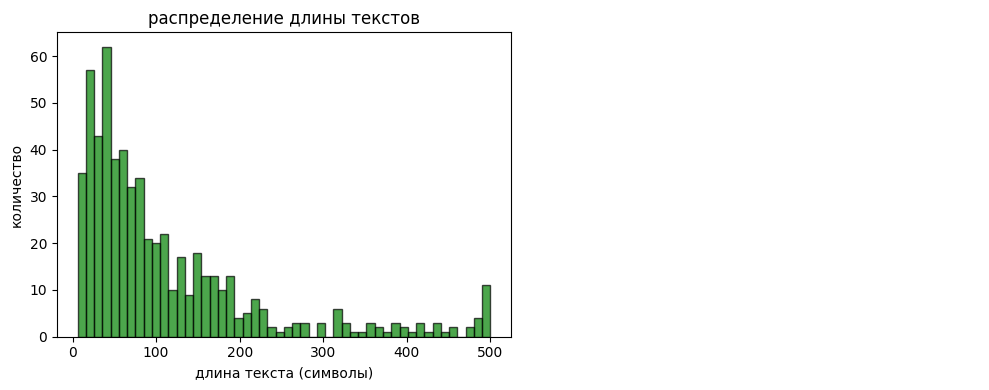

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

"""

Работу выполнил:
Студент 4 курса бакалавриата ЧОУ МУИВ
группы ИСс 23.1/Б3-22
Кириллов Григорий Михайлович

Блок кода отвечающий за анализ и предобработку данных 
двух датасетов radio speech. 

"""

df = pd.read_csv('combined_dataset.csv')
print(f"размер датасета: {df.shape}")
print(f"колонки: {df.columns.tolist()}")
print(f"всего записей: {len(df):,}")
print(f"пропущенные значения:")
print(df.isnull().sum())
print(df['duration'].describe())

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['duration'], bins=100, alpha=0.7, edgecolor='black')
plt.title('распределение длительностей')
plt.xlabel('длительность (секунды)')
plt.ylabel('количество')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['duration']), bins=100, alpha=0.7, edgecolor='black', color='orange')
plt.title('распределение длительностей (log scale)')
plt.xlabel('log(длительность)')
plt.ylabel('количество')

plt.tight_layout()
plt.show()

print("\n =================== анализ структуры данных ===================")
df['dataset_type'] = df['audio_path'].str.split('/').str[0]
print(df['dataset_type'].value_counts())

print("\n =================== проверка доступности файлов =================== ")
def check_files_existence(df, sample_size=100):
    audio_exists = []
    text_exists = []
    
    sample_indices = np.random.choice(len(df), size=min(sample_size, len(df)), replace=False)
    
    for idx in tqdm(sample_indices, desc="проверка файлов"):
        row = df.iloc[idx]
        audio_exists.append(os.path.exists(row['audio_path']))
        text_exists.append(os.path.exists(row['text_path']))
    
    audio_success = np.mean(audio_exists) * 100
    text_success = np.mean(text_exists) * 100
    
    print(f"аудио файлы: {audio_success:.1f}% доступно")
    print(f"текст файлы: {text_success:.1f}% доступно")
    
    return audio_success, text_success

audio_success, text_success = check_files_existence(df)

print("\n =================== предобраотка текста =================== ")

def load_text_sample(text_path):
    try:
        with open(text_path, 'r', encoding='utf-8') as f:
            return f.read().strip()
    except:
        return ""

sample_indices = np.random.choice(len(df), size=min(1000, len(df)), replace=False)
texts = []

for idx in tqdm(sample_indices, desc="загрузка текстов"):
    text_path = df.iloc[idx]['text_path']
    if os.path.exists(text_path):
        text = load_text_sample(text_path)
        texts.append(text)

text_lengths = [len(text) for text in texts if text]
print(f"средняя длина текста: {np.mean(text_lengths):.1f} символов")
print(f"медианная длина текста: {np.median(text_lengths):.1f} символов")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, alpha=0.7, edgecolor='black', color='green')
plt.title('распределение длины текстов')
plt.xlabel('длина текста (символы)')
plt.ylabel('количество')

plt.subplot(1, 2, 2)
print("примеры текстов:")
for i in range(min(3, len(texts))):
    print(f"'{texts[i][:100]}...'")

plt.axis('off')
plt.tight_layout()
plt.show()

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

def create_clean_dataset_v2(df, min_duration=6.0, max_duration=15.0):
    """
    Создаёт очищенную версию датасета, включающую ТОЛЬКО записи
    с длительностью от min_duration до max_duration секунд.
    
    """

    print(f"Исходный размер: {len(df):,} записей")
    
    clean_df = df.dropna().copy()
    print(f"После удаления пропусков: {len(clean_df):,} записей")
    
    duration_mask = (clean_df['duration'] >= min_duration) & (clean_df['duration'] <= max_duration)
    clean_df = clean_df[duration_mask]
    print(f"После фильтрации по длительности ({min_duration}–{max_duration} сек): {len(clean_df):,} записей")
    
    tqdm.pandas(desc="Проверка аудио файлов")
    clean_df['audio_exists'] = clean_df['audio_path'].progress_apply(os.path.exists)
    
    tqdm.pandas(desc="Проверка текстовых файлов")
    clean_df['text_exists'] = clean_df['text_path'].progress_apply(os.path.exists)
    
    file_mask = clean_df['audio_exists'] & clean_df['text_exists']
    clean_df = clean_df[file_mask]
    
    clean_df = clean_df.drop(['audio_exists', 'text_exists'], axis=1).reset_index(drop=True)
    
    print(f"После проверки доступности файлов: {len(clean_df):,} записей")
    
    print(f"\n{'='*60}")
    print(f"ОЧИЩЕННЫЙ ДАТАСЕТ (duration ∈ [{min_duration}, {max_duration}] сек)")
    print(f"Записей: {len(clean_df):,}")
    if len(clean_df) > 0:
        print(f"min duration: {clean_df['duration'].min():.2f} сек")
        print(f"max duration: {clean_df['duration'].max():.2f} сек")
        print(f"mean duration: {clean_df['duration'].mean():.2f} сек")
        print(f"median duration: {clean_df['duration'].median():.2f} сек")
        
        if 'dataset_type' not in clean_df.columns:
            clean_df['dataset_type'] = clean_df['audio_path'].str.split('/').str[0]
        print("\nРаспределение по источникам:")
        print(clean_df['dataset_type'].value_counts())
    
    return clean_df

def main():
    df = pd.read_csv('combined_dataset.csv')
    
    clean_df_v2 = create_clean_dataset_v2(df, min_duration=6.0, max_duration=15.0)
    
    output_path = 'clean_dataset_v2.csv'
    clean_df_v2.to_csv(output_path, index=False)
    print(f"\nСохранено: '{output_path}'")
    
    return clean_df_v2

# Запуск
if __name__ == "__main__":
    clean_df_v2 = main()

Исходный размер: 1,121,442 записей
После удаления пропусков: 1,121,439 записей
После фильтрации по длительности (6.0–15.0 сек): 355,132 записей


Проверка текстовых файлов: 100%|██████████| 355132/355132 [00:00<00:00, 417236.20it/s]


После проверки доступности файлов: 182,655 записей

ОЧИЩЕННЫЙ ДАТАСЕТ (duration ∈ [6.0, 15.0] сек)
Записей: 182,655
min duration: 6.00 сек
max duration: 15.00 сек
mean duration: 9.40 сек
median duration: 8.90 сек

Распределение по источникам:
dataset_type
radio_2    182655
Name: count, dtype: int64

Сохранено: 'clean_dataset_v2.csv'


In [3]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [4]:
def check_environment():

    """
    Блок кода отвечающий за проверку доступности GPU и ресурсов
    
    """

    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    import psutil
    ram_gb = psutil.virtual_memory().total / 1024**3 # ОЗУ
    print(f"system RAM: {ram_gb:.1f} GB")
    
    disk_free = psutil.disk_usage('.').free / 1024**3 # диск
    print(f"free disk space: {disk_free:.1f} GB")


check_environment()

PyTorch version: 2.9.1+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 11.6 GB
system RAM: 30.4 GB
free disk space: 565.6 GB


In [ ]:
class DeepSpeechVocabulary:
    def __init__(self):
        # Определяем алфавит: строчные буквы, пробел, цифры, пунктуация
        chars = [
            ' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н',
            'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я',
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            '!', '?', ',', '.', '-', ':', ';', '(', ')', '"', "'"
        ]
        
        # Blank всегда имеет индекс 0 (требование CTC)
        self.char_to_idx = {'<blank>': 0}
        for i, ch in enumerate(chars, start=1):
            self.char_to_idx[ch] = i
        
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        self.blank_id = 0
        
        print(f"DeepSpeech2 vocabulary создан: {self.vocab_size} токенов (включая blank)")

    def text_to_indices(self, text):
        """
        Преобразует текст в список индексов без blank.
        """
        indices = []
        for char in text.lower():
            if char in self.char_to_idx:
                indices.append(self.char_to_idx[char])
        return indices

    def indices_to_text(self, indices):
        """
        Преобразует список индексов (после CTC decoding) в текст.
        """
        text = []
        for idx in indices:
            if idx != self.blank_id and idx in self.idx_to_char:
                text.append(self.idx_to_char[idx])
        return ''.join(text)

In [6]:
import os
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm

SAMPLE_RATE = 16000
N_MELS = 80

def audio_to_mel_npy(audio_path, npy_path):
    try:
        audio, sr = sf.read(audio_path)
        if sr != SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=512, hop_length=160
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel = (log_mel + 100) / 100.0
        np.save(npy_path, log_mel.astype(np.float32))
        return True
    except Exception as e:
        print(f"Ошибка: {audio_path} - {e}")
        return False

df = pd.read_csv('clean_dataset_v2.csv')
print(f"Обработка {len(df)} файлов")

for idx, row in tqdm(df.iterrows(), total=len(df)):
    opus_path = row['audio_path']
    if not os.path.exists(opus_path):
        continue
    npy_path = opus_path.replace('.opus', '.npy')
    if not os.path.exists(npy_path):
        os.makedirs(os.path.dirname(npy_path), exist_ok=True)
        audio_to_mel_npy(opus_path, npy_path)

print("Предобработка завершена")

Обработка 182655 файлов


100%|██████████| 182655/182655 [00:03<00:00, 59948.01it/s]

Предобработка завершена


In [7]:
import os
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm

SAMPLE_RATE = 16000
N_MELS = 80

def audio_to_mel_npy(audio_path, npy_path):
    try:
        audio, sr = sf.read(audio_path)
        if sr != SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=512, hop_length=160
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel = (log_mel + 100) / 100.0
        np.save(npy_path, log_mel.astype(np.float32))
        return True
    except Exception as e:
        print(f"Ошибка: {audio_path} - {e}")
        return False

df = pd.read_csv('clean_dataset_v2.csv')
print(f"Обработка {len(df)} файлов")

for idx, row in tqdm(df.iterrows(), total=len(df)):
    opus_path = row['audio_path']
    if not os.path.exists(opus_path):
        continue
    npy_path = opus_path.replace('.opus', '.npy')
    if not os.path.exists(npy_path):
        os.makedirs(os.path.dirname(npy_path), exist_ok=True)
        audio_to_mel_npy(opus_path, npy_path)

df['audio_path'] = df['audio_path'].str.replace('.opus', '.npy')
df.to_csv('clean_dataset_v2_preprocessed.csv', index=False)

print("Предобработка завершена. Создан clean_dataset_v2_preprocessed.csv")

Обработка 182655 файлов


100%|██████████| 182655/182655 [00:03<00:00, 60135.16it/s]


Предобработка завершена. Создан clean_dataset_v2_preprocessed.csv


Устройство: cuda


/home/grigory/ML/diploms/kirillov/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Параметры модели: 5,212,504


Эпоха 1/9: 100%|██████████| 1427/1427 [20:28<00:00,  1.16it/s, loss=1.312]


Эпоха 1 завершена. Средний loss: 2.089


Эпоха 2/9: 100%|██████████| 1427/1427 [20:00<00:00,  1.19it/s, loss=0.985]


Эпоха 2 завершена. Средний loss: 1.131


Эпоха 3/9: 100%|██████████| 1427/1427 [19:54<00:00,  1.19it/s, loss=0.895]


Эпоха 3 завершена. Средний loss: 0.952


Эпоха 4/9: 100%|██████████| 1427/1427 [19:57<00:00,  1.19it/s, loss=0.871]


Эпоха 4 завершена. Средний loss: 0.862


Эпоха 5/9: 100%|██████████| 1427/1427 [19:59<00:00,  1.19it/s, loss=0.917]


Эпоха 5 завершена. Средний loss: 0.804


Эпоха 6/9: 100%|██████████| 1427/1427 [20:02<00:00,  1.19it/s, loss=0.769]


Эпоха 6 завершена. Средний loss: 0.764


Эпоха 7/9: 100%|██████████| 1427/1427 [19:55<00:00,  1.19it/s, loss=0.744]


Эпоха 7 завершена. Средний loss: 0.733


Эпоха 8/9: 100%|██████████| 1427/1427 [19:56<00:00,  1.19it/s, loss=0.743]


Эпоха 8 завершена. Средний loss: 0.710


Эпоха 9/9: 100%|██████████| 1427/1427 [19:56<00:00,  1.19it/s, loss=0.757]


Эпоха 9 завершена. Средний loss: 0.690
Модель сохранена как 'Deepsearch_model.pth'


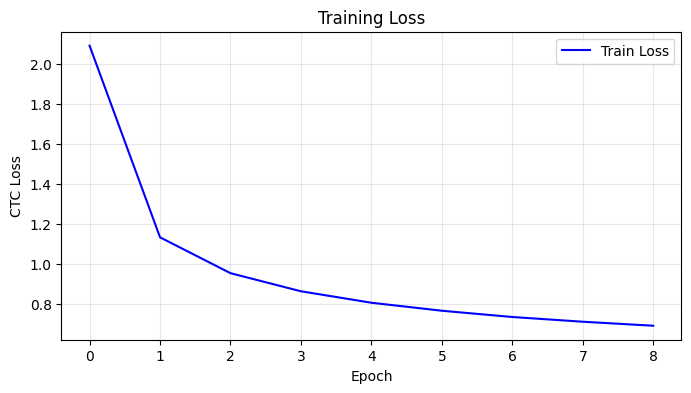

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ==================== CONFIG ====================
class Config:
    SAMPLE_RATE = 16000
    N_MELS = 80
    MAX_DURATION = 12.0
    BATCH_SIZE = 128
    NUM_EPOCHS = 9
    LEARNING_RATE = 1e-3
    DROPOUT = 0.3
    NUM_WORKERS = 0     
    PIN_MEMORY = False   

config = Config()

# ==================== VOCABULARY ====================
class DeepSpeechVocabulary:
    def __init__(self):
        chars = [
            ' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н',
            'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я',
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            '!', '?', ',', '.', '-', ':', ';', '(', ')', '"', "'"
        ]
        self.char_to_idx = {'<blank>': 0}
        for i, ch in enumerate(chars, start=1):
            self.char_to_idx[ch] = i
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        self.blank_id = 0

    def text_to_indices(self, text):
        indices = []
        for char in text.lower():
            if char in self.char_to_idx:
                indices.append(self.char_to_idx[char])
        return indices

    def indices_to_text(self, indices):
        return ''.join(self.idx_to_char[idx] for idx in indices if idx != self.blank_id)

# ==================== DATASET (ТОЛЬКО .npy) ====================
class DeepSpeechDataset(Dataset):
    def __init__(self, df, vocab):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        npy_path = row['audio_path']
        text_path = row['text_path']
        
        # Загрузка мел-спектрограммы
        if os.path.exists(npy_path):
            log_mel = np.load(npy_path)
        else:
            log_mel = np.zeros((config.N_MELS, 100), dtype=np.float32)
        
        try:
            with open(text_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
        except:
            text = ""
        token_ids = self.vocab.text_to_indices(text)
        
        return {
            'features': log_mel.astype(np.float32),  # (n_mels, T)
            'token_ids': token_ids,
            'text': text
        }

# ==================== COLLATE FN ====================
def collate_fn(batch):
    max_t = max(item['features'].shape[1] for item in batch)
    batch_features = []
    feature_lengths = []
    
    for item in batch:
        feat = item['features']
        _, t = feat.shape
        if t < max_t:
            feat = np.pad(feat, ((0, 0), (0, max_t - t)), mode='constant', constant_values=0.0)
        batch_features.append(torch.from_numpy(feat))
        feature_lengths.append(t)
    
    features = torch.stack(batch_features, dim=0)  # (B, n_mels, T)
    feature_lengths = torch.tensor(feature_lengths, dtype=torch.long)
    
    token_ids = [torch.tensor(item['token_ids'], dtype=torch.long) for item in batch]
    token_lengths = torch.tensor([len(ids) for ids in token_ids], dtype=torch.long)
    tokens = torch.nn.utils.rnn.pad_sequence(token_ids, batch_first=True, padding_value=0)
    
    return {
        'features': features,
        'tokens': tokens,
        'feature_lengths': feature_lengths,
        'token_lengths': token_lengths,
        'raw_texts': [item['text'] for item in batch]
    }

# ==================== MODEL ====================
class DeepSpeech2(nn.Module):
    def __init__(self, vocab_size, n_mels=80, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20),
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20)
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_mels, 100)
            out = self.conv(dummy)
            rnn_input_size = out.size(1) * out.size(2)
        
        self.hidden_size = 320
        self.rnn = nn.LSTM(
            input_size=rnn_input_size,
            hidden_size=self.hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(self.hidden_size * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, n_mels, T)
        x = self.conv(x)    # (B, 32, H, T')
        b, c, h, t = x.shape
        x = x.permute(0, 3, 1, 2).contiguous().view(b, t, c * h)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        return self.fc(x)

# ==================== UTILS ====================
def compute_output_lengths(input_lengths):
    T1 = (input_lengths + 2*5 - 11) // 2 + 1
    T2 = T1 + 2*5 - 11 + 1
    return torch.clamp(T2, min=1)

# ==================== TRAINING ====================
def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Устройство: {device}")
    
    # Загрузка ПРЕДОБРАБОТАННОГО датасета
    df = pd.read_csv('clean_dataset_v2_preprocessed.csv')
    vocab = DeepSpeechVocabulary()
    dataset = DeepSpeechDataset(df, vocab)
    loader = DataLoader(
        dataset, batch_size=config.BATCH_SIZE, shuffle=True,
        num_workers=config.NUM_WORKERS, collate_fn=collate_fn, pin_memory=config.PIN_MEMORY
    )
    
    model = DeepSpeech2(vocab.vocab_size, n_mels=config.N_MELS, dropout=config.DROPOUT).to(device)
    print(f"Параметры модели: {sum(p.numel() for p in model.parameters()):,}")
    
    criterion = nn.CTCLoss(blank=vocab.blank_id, zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    scaler = GradScaler('cuda')
    
    train_losses = []
    
    for epoch in range(config.NUM_EPOCHS):
        model.train()
        total_loss = 0.0
        pbar = tqdm(loader, desc=f"Эпоха {epoch+1}/{config.NUM_EPOCHS}")
        for batch in pbar:
            features = batch['features'].to(device, non_blocking=True)
            tokens = batch['tokens'].to(device, non_blocking=True)
            feat_lens = batch['feature_lengths'].to(device, non_blocking=True)
            tok_lens = batch['token_lengths'].to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            with autocast('cuda'):
                logits = model(features)
                output_lengths = compute_output_lengths(feat_lens)
                log_probs = F.log_softmax(logits, dim=-1).transpose(0, 1)
                loss = criterion(log_probs, tokens, output_lengths, tok_lens)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.3f}"})
        
        avg_loss = total_loss / len(loader)
        train_losses.append(avg_loss)
        print(f"Эпоха {epoch+1} завершена. Средний loss: {avg_loss:.3f}")
    
    # Сохранение
    torch.save(model.state_dict(), 'Deepsearch_model.pth')
    print("Модель сохранена как 'Deepsearch_model.pth'")
    
    # График
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('CTC Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    train()

In [ ]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

"""
Блок кода отвечающий за создание vocab, dataloader для обучения моделей

"""

# ==================== CONFIG ====================
class Config:
    SAMPLE_RATE = 16000
    N_MELS = 80
    MAX_DURATION = 15.0

config = Config()

# ==================== VOCABULARY ====================
class DeepSpeechVocabulary:
    def __init__(self):
        chars = [
            ' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н',
            'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я',
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            '!', '?', ',', '.', '-', ':', ';', '(', ')', '"', "'"
        ]
        self.char_to_idx = {'<blank>': 0}
        for i, ch in enumerate(chars, start=1):
            self.char_to_idx[ch] = i
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        self.blank_id = 0

    def indices_to_text(self, indices):
        return ''.join(self.idx_to_char[idx] for idx in indices if idx != self.blank_id)

# ==================== DATASET ====================
class EvalDataset(Dataset):
    def __init__(self, df, sample_rate=16000, n_mels=80, max_duration=15.0):
        self.df = df.reset_index(drop=True)
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.max_samples = int(max_duration * sample_rate)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['audio_path']
        text_path = row['text_path']
        
        # Загрузка аудио
        try:
            if audio_path.endswith('.npy'):
                log_mel = np.load(audio_path)
            else:
                audio, sr = sf.read(audio_path)
                if sr != self.sample_rate:
                    audio = librosa.resample(audio, orig_sr=sr, target_sr=self.sample_rate)
                if len(audio) > self.max_samples:
                    audio = audio[:self.max_samples]
                else:
                    audio = np.pad(audio, (0, self.max_samples - len(audio)), mode='constant')
                mel_spec = librosa.feature.melspectrogram(
                    y=audio, sr=self.sample_rate, n_mels=self.n_mels, n_fft=512, hop_length=160
                )
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)
                log_mel = (log_mel + 100) / 100.0
        except:
            log_mel = np.zeros((self.n_mels, 100), dtype=np.float32)
        
        # Текст
        try:
            with open(text_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
        except:
            text = ""
        
        return {
            'features': log_mel.astype(np.float32),
            'text': text,
            'audio_path': audio_path
        }

# ==================== COLLATE FN ====================
def collate_eval(batch):
    max_t = max(item['features'].shape[1] for item in batch)
    features = []
    texts = []
    paths = []
    lengths = []
    
    for item in batch:
        feat = item['features']
        _, t = feat.shape
        if t < max_t:
            feat = np.pad(feat, ((0, 0), (0, max_t - t)), mode='constant')
        features.append(torch.from_numpy(feat))
        texts.append(item['text'])
        paths.append(item['audio_path'])
        lengths.append(t)
    
    features = torch.stack(features, dim=0)  # (B, n_mels, T)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return features, texts, paths, lengths

# ==================== MODEL (DeepSpeech2 CTC-only) ====================
class DeepSpeech2(nn.Module):
    def __init__(self, vocab_size, n_mels=80, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20),
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20)
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_mels, 100)
            out = self.conv(dummy)
            rnn_input_size = out.size(1) * out.size(2)
        self.rnn = nn.LSTM(rnn_input_size, 320, 2, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(640, vocab_size)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        b, c, h, t = x.shape
        x = x.permute(0, 3, 1, 2).contiguous().view(b, t, c * h)
        x, _ = self.rnn(x)
        return self.fc(x)

# ==================== CER CALCULATION ====================
def calculate_cer(ref, hyp):
    from difflib import SequenceMatcher
    if not ref:
        return 1.0
    return 1 - SequenceMatcher(None, ref.lower(), hyp.lower()).ratio()

# ==================== EVALUATION ====================
def evaluate():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Устройство: {device}")
    
    # Загрузка данных
    df = pd.read_csv('test_ev.csv')
    dataset = EvalDataset(df, max_duration=config.MAX_DURATION)
    loader = DataLoader(dataset, batch_size=64, shuffle=False, collate_fn=collate_eval, num_workers=0)
    
    # Загрузка модели
    vocab = DeepSpeechVocabulary()
    model = DeepSpeech2(vocab.vocab_size).to(device)
    model.load_state_dict(torch.load('Deepsearch_model.pth', map_location=device))
    model.eval()
    
    total_cer = 0.0
    total_samples = 0
    results = []
    
    print("Оценка модели")
    with torch.no_grad():
        for features, texts, paths, lengths in tqdm(loader):
            features = features.to(device)
            logits = model(features)
            preds = torch.argmax(logits, dim=-1)  # (B, T)
            
            for i in range(len(texts)):
                pred_seq = preds[i].cpu().tolist()
                decoded = []
                prev = vocab.blank_id
                for p in pred_seq:
                    if p != prev and p != vocab.blank_id:
                        decoded.append(p)
                    prev = p
                hyp = vocab.indices_to_text(decoded)
                ref = texts[i]
                
                cer = calculate_cer(ref, hyp)
                total_cer += cer
                total_samples += 1
                
                results.append({
                    'audio_path': paths[i],
                    'reference': ref,
                    'prediction': hyp,
                    'cer': cer
                })
    
    avg_cer = (total_cer / total_samples) * 100
    print(f"\nСредний CER: {avg_cer:.2f}%")
    print(f"Всего примеров: {total_samples}")
    
    results_df = pd.DataFrame(results)
    results_df.to_csv('evaluation_results.csv', index=False)
    print("Результаты сохранены в 'evaluation_results.csv'")
    
    print("\nПримеры предсказаний:")
    for i in range(min(5, len(results))):
        r = results[i]
        print(f"\nОригинал: {r['reference']}")
        print(f"Предсказание: {r['prediction']}")
        print(f"CER: {r['cer']*100:.1f}%")

if __name__ == "__main__":
    evaluate()

Устройство: cuda
Оценка модели


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Средний CER: 13.78%
Всего примеров: 30
Результаты сохранены в 'evaluation_results.csv'

Примеры предсказаний:

Оригинал: а две три знаете как к носу ивана ивановича прибавить можно и этому нарисовать крестик и этому каждому по крестику нарисовать вроде как получилось что полный политический спектр ты
Предсказание: иберенае каотгоголя к нос иван ванчтопрб в може  этому нарисовать кристикаэтомур всекажм по кристику нарисовать ну броде как получилась  полный политический спектор
CER: 20.9%

Оригинал: все и сейчас это то же самое обама предлагает мы обсуждаем обама делает мы обсуждаем нато что то делает мы обсуждаем ну давайте что нибудь кремль предложил сделал а потом весь мир будет этого не происходит и
Предсказание: и и сечас ь то же самобам предлагает мы обсуждаем  обамы делат мы обсуждаем нато чео делать м обсужда давайте  кремль подложилаь сдела а потом есть мер бт а это дру не происходит
CER: 16.4%

Оригинал: вот после всего что сделал эдуард лимонов за последние один* пять года и 

In [3]:
from torchinfo import summary
from main import DeepSpeech2, Config

config = Config()
model = DeepSpeech2(vocab_size=58, n_mels=config.N_MELS)
summary(model, input_size=(1, 80, 1000))

Layer (type:depth-idx)                   Output Shape              Param #
DeepSpeech2                              [1, 500, 58]              --
├─Sequential: 1-1                        [1, 32, 20, 500]          --
│    └─Conv2d: 2-1                       [1, 32, 40, 500]          14,464
│    └─BatchNorm2d: 2-2                  [1, 32, 40, 500]          64
│    └─Hardtanh: 2-3                     [1, 32, 40, 500]          --
│    └─Conv2d: 2-4                       [1, 32, 20, 500]          236,576
│    └─BatchNorm2d: 2-5                  [1, 32, 20, 500]          64
│    └─Hardtanh: 2-6                     [1, 32, 20, 500]          --
├─LSTM: 1-2                              [1, 500, 640]             4,925,440
├─Linear: 1-3                            [1, 500, 58]              37,178
Total params: 5,213,786
Trainable params: 5,213,786
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 5.12
Input size (MB): 0.32
Forward/backward pass size (MB): 18.15
Params size (MB): 20.86
Esti